# Machine Configuration

In [1]:
import glob
import pandas as pd
import numpy as np
import ntpath
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import time
%matplotlib inline


## Helpers:
def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

In [2]:
myhost = os.environ['COMPUTERNAME']

if(myhost == "TIMO-LAPTOP"):
    OMNETPP_PATH = "C:\\omnet\\omnetpp-5.5.1\\"
    SDN4CORE_PATH = "/C/Users/micro/workspace/omnet/SDN4CoRE/"
elif(myhost == "DESKTOP-32GAH82"):
    OMNETPP_PATH = "C:\\omnet\\omnetpp-5.5.1\\"
    SDN4CORE_PATH = "/C/Users/Timo/Workspace/omnet/SDN4CoRE/"

SIMULATION_PATH = SDN4CORE_PATH + "examples/papers/vtc2023spring/scaling/"


# Scavetool -- parse filtered result files into csv

In [12]:
# MODULE_FILTER = "**.publishers**.middleware.**"
MODULE_FILTER = "**middleware**"
RESULTFILES_PATTERNS = {
    # "./results/Switch_Switches_Study*", 
    # "./results/SDN_Switches_Study*",
    # "./results/Switch_MultSubPerPub_Study*", 
    # "./results/SDN_MultSubPerPub_Study*", 
    # "./results/Switch_SwitchesMultSub_Study*", 
    # "./results/SDN_SwitchesMultSub_Study*",
    # "./results/SDNVanilla_SwitchesMultSub_Study*"
    "./results/SecVI*"
    }

In [13]:
for RESULTFILES_PATTERN in RESULTFILES_PATTERNS:
    resultfiles = glob.glob(RESULTFILES_PATTERN + ".sca")
    for resultfile in resultfiles:
        command = OMNETPP_PATH + "tools\win64\\msys2_shell.cmd -mingw64 -ic \"echo " + resultfile.replace("\\","/").replace(".sca",".*") + "; scavetool x " + SIMULATION_PATH + resultfile.replace("\\","/") + " " + SIMULATION_PATH + resultfile.replace("\\","/").replace(".sca",".vec") + " -f \'module(" + MODULE_FILTER + ")\'" + " -o " + SIMULATION_PATH + resultfile.replace("\\","/").replace(".sca",".csv") + "; sleep 5\""
        os.environ["HOME"] = OMNETPP_PATH
        os.system(command)
        time.sleep(0.5)

# Parse and Plot

### SecVI Study

In [17]:
CSV_FILE_PATTERN = "./results/SecVI*"
STARTTIME = 0.001 # 1ms
csv_files = glob.glob(CSV_FILE_PATTERN + ".csv")
print(len(csv_files))
lastRemote = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="scalar") & (study.name=="endpointCreatedAt:sum")]
    lastRemote[csv_file.split("_")[1].split("-")[0]] = filtered["value"].max()-STARTTIME
lastRemote


3


{'Ethernet': 0.00032931400000000004,
 'SDN': 0.000762043,
 'SDNVanilla': 0.0011248170000000002}

### Switches Study

In [6]:
# CSV_FILE_PATTERN = "./results/Switch_Switches_Study*"
CSV_FILE_PATTERN = "./results/SDN_Switches_Study*"

In [7]:
csv_files = glob.glob(CSV_FILE_PATTERN + "processing.csv")
lastRemote = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="vector") & (study.name=="remotes:vector(constant1)")]
    tmp = csv_file.split("-")[1].split(",")
    S = int(tmp[0].split("=")[1])
    N = int(tmp[1].split("=")[1])
    if S not in lastRemote:
        lastRemote[S] = dict()
    lastRemote[S][N] = filtered["vectime"].max()[0]
    # lastRemoteMin[S][N] = filtered["vectime"].min()[0]

In [19]:
df = pd.DataFrame(lastRemote)
df = df.transpose()
df = df.sort_index()
# df.to_csv(CSV_FILE_PATTERN.split('*')[0] + "_switches.csv")


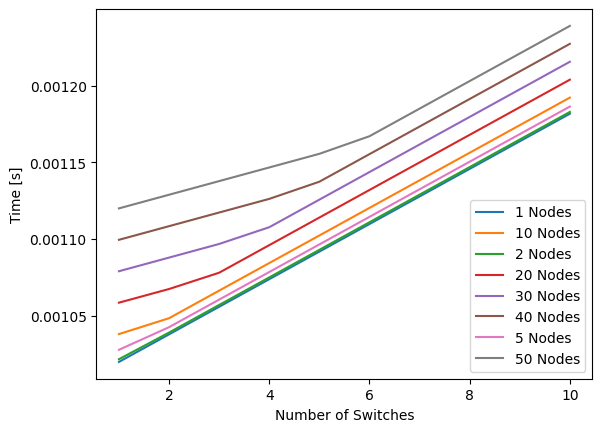

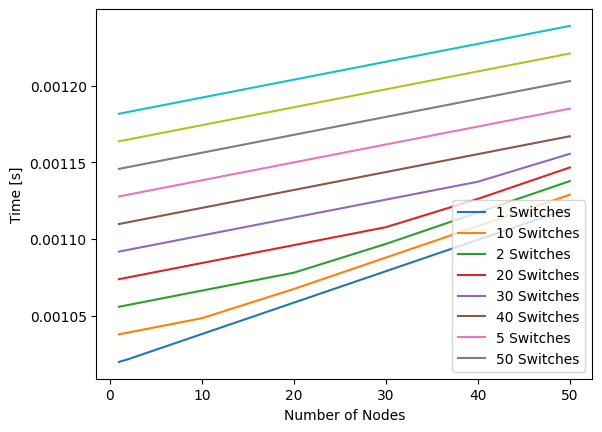

In [20]:
plt11 = df.plot()
plt11.set_xlabel("Number of Switches")
plt11.set_ylabel("Time [s]")
plt11.legend([str(x) + " Nodes" for x in df.columns])
plt11
plt12 = df.transpose().sort_index().plot()
plt12.set_xlabel("Number of Nodes")
plt12.set_ylabel("Time [s]")
plt12.legend([str(x) + " Switches" for x in df.columns])

### Multiple Subscribers per Publisher Study

In [21]:
# CSV_FILE_PATTERN = "./results/Switch_MultSubPerPub_Study*"
CSV_FILE_PATTERN = "./results/SDN_MultSubPerPub_Study*"

In [25]:
csv_files = glob.glob(CSV_FILE_PATTERN + ".csv")
lastRemote = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="vector") & (study.name=="remotes:vector(constant1)")]
    tmp = csv_file.split("-")[1].split(",")
    P = int(tmp[0].split("=")[1])
    C = int(tmp[1].split("=")[1])
    # print (P, C)
    if P not in lastRemote:
        lastRemote[P] = dict()
    # find the maximum value in the matrix
    # print(type(filtered["vectime"]))
    maximum = 0
    for dim1 in filtered["vectime"]:
        for dim2 in dim1:
            maximum = dim2.max() if dim2.max() > maximum else maximum
    lastRemote[P][C] = maximum
    # lastRemoteMin[P][C] = filtered["vectime"].min()[0]
lastRemote

{}

In [23]:
df = pd.DataFrame(lastRemote)
df = df.sort_index()
plt11 = df.plot()
plt11.set_xlabel("Number of Producers")
plt11.set_ylabel("Time [s]")
plt11.legend([str(x) + " Consumers" for x in df.columns])

TypeError: no numeric data to plot

### Switches and Multiple PubSubs Combined Study

#### Parse and combine in csv

In [14]:
# CSV_FILE_PATTERN = "./results/Switch_SwitchesMultSub_Study*"
CSV_FILE_PATTERN = "./results/SDN_SwitchesMultSub_Study*"
# CSV_FILE_PATTERN = "./results/SDNVanilla_SwitchesMultSub_Study*"
STARTTIME = 0.001 # 1ms
csv_files = glob.glob(CSV_FILE_PATTERN + ".csv")
print(len(csv_files))
lastRemote = dict()
for csv_file in csv_files:
    study = pd.read_csv(csv_file, converters = {
        'attrvalue': parse_if_number,
        'binedges': parse_ndarray,
        'binvalues': parse_ndarray,
        'vectime': parse_ndarray,
        'vecvalue': parse_ndarray})
    filtered = study[(study.type=="scalar") & (study.name=="endpointCreatedAt:sum")]
    tmp = csv_file.split("-")[1].split(",")
    S = int(tmp[0].split("=")[1])
    P = int(tmp[1].split("=")[1])
    C = int(tmp[2].split("=")[1])
    if S not in lastRemote:
        lastRemote[S] = dict()
    if P not in lastRemote[S]:
        lastRemote[S][P] = dict()
    lastRemote[S][P][C] = filtered["value"].max()-STARTTIME

3


IndexError: list index out of range

In [8]:
# export last remote to csv in colums Switches, Producers, Consumers, Time
SEP = ";"
# sort lastRemote by number of switches
lastRemote = {k: v for k, v in sorted(lastRemote.items(), key=lambda item: item[0])}
# sort every dict in lastRemote by number of producers
for k, v in lastRemote.items():
    lastRemote[k] = {k2: v2 for k2, v2 in sorted(v.items(), key=lambda item: item[0])}
    # sort every dict in lastRemote by number of consumers
    for k2, v2 in v.items():
        lastRemote[k][k2] = {k3: v3 for k3, v3 in sorted(v2.items(), key=lambda item: item[0])}
with open(CSV_FILE_PATTERN.split('/')[2].split('*')[0] + ".csv", "w") as f:
    f.write("Switches" + SEP +" Producers" + SEP + " Consumers" + SEP + " Time\n")
    for S in lastRemote:
        for P in lastRemote[S]:
            for C in lastRemote[S][P]:
                f.write(str(S) + SEP + str(P) + SEP + str(C) + SEP + str(lastRemote[S][P][C]) + "\n")

#### Plot

In [9]:
RESULTFILES_PATTERNS = {
    "Switch_SwitchesMultSub_Study.csv",
    "SDN_SwitchesMultSub_Study.csv",
    "SDNVanilla_SwitchesMultSub_Study.csv"
}
for CSV_FILE_PATTERN in RESULTFILES_PATTERNS:
    # import last remote from csv
    with open(CSV_FILE_PATTERN, "r") as f:
        lines = f.readlines()
        lastRemote = dict()
        for line in lines[1:]:
            S, P, C, T = line.split("\n")[0].split(SEP)
            S = int(S)
            P = int(P)
            C = int(C)
            T = float(T)
            if S not in lastRemote:
                lastRemote[S] = dict()
            if C not in lastRemote[S]:
                lastRemote[S][C] = dict()
            lastRemote[S][C][P] = T
    if(CSV_FILE_PATTERN == "Switch_SwitchesMultSub_Study.csv"):
        switches = lastRemote
    elif(CSV_FILE_PATTERN == "SDN_SwitchesMultSub_Study.csv"):
        sdn = lastRemote
    elif(CSV_FILE_PATTERN == "SDNVanilla_SwitchesMultSub_Study.csv"):
        vanilla = lastRemote

##### Full Study

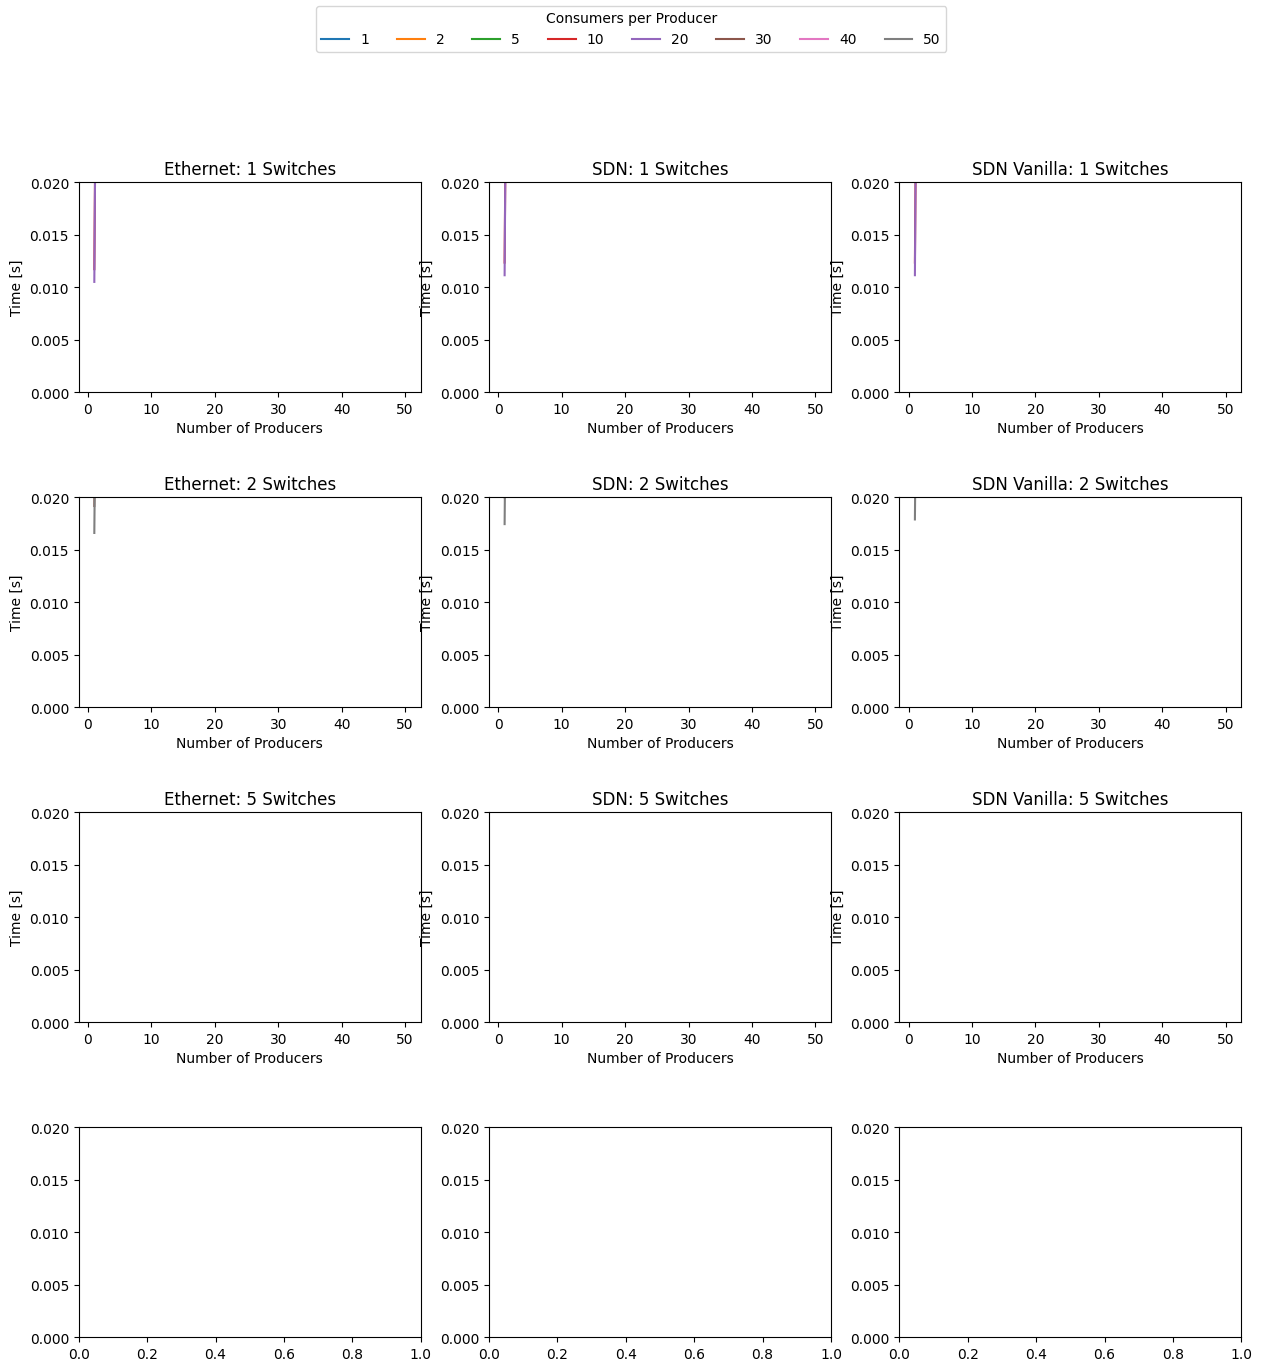

In [14]:
df_switches = dict()
df_sdn = dict()
df_vanilla = dict()
for S in switches:
    df_switches[S] = pd.DataFrame(switches[S])
    df_sdn[S] = pd.DataFrame(sdn[S])
    df_vanilla[S] = pd.DataFrame(vanilla[S])
# create 3 subplots switches, sdn, vanilla for each number of switches
fig, axs = plt.subplots(4,3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
# set y max to 0.2
for ax in axs.flat:
    ax.set_ylim(0, 0.02)
row = 0
for S in switches:
    plt1 = df_switches[S].plot(ax=axs[row,0], legend=False)
    plt1.set_xlabel("Number of Producers")
    plt1.set_ylabel("Time [s]")
    plt1.set_title("Ethernet: " + str(S) + " Switches")
    # plt1.legend([str(x) + " Consumers per Producer" for x in df_switches[S].columns])
    plt2 = df_sdn[S].plot(ax=axs[row,1], legend=False)
    plt2.set_xlabel("Number of Producers")
    plt2.set_ylabel("Time [s]")
    plt2.set_title("SDN: " + str(S) + " Switches")
    # plt2.legend([str(x) + " Consumers per Producer" for x in df_sdn[S].columns])
    plt3 = df_vanilla[S].plot(ax=axs[row,2], legend=False)
    plt3.set_xlabel("Number of Producers")
    plt3.set_ylabel("Time [s]")
    plt3.set_title("SDN Vanilla: " + str(S) + " Switches")
    # plt3.legend([str(x) + " Consumers per Producer" for x in df_vanilla[S].columns])
    row+=1
# set legend for all subplots and append Consumers per Producer to legend
handles, labels = plt1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=8, title="Consumers per Producer")
plt.show()



##### Switches and 1 + 50 Subs

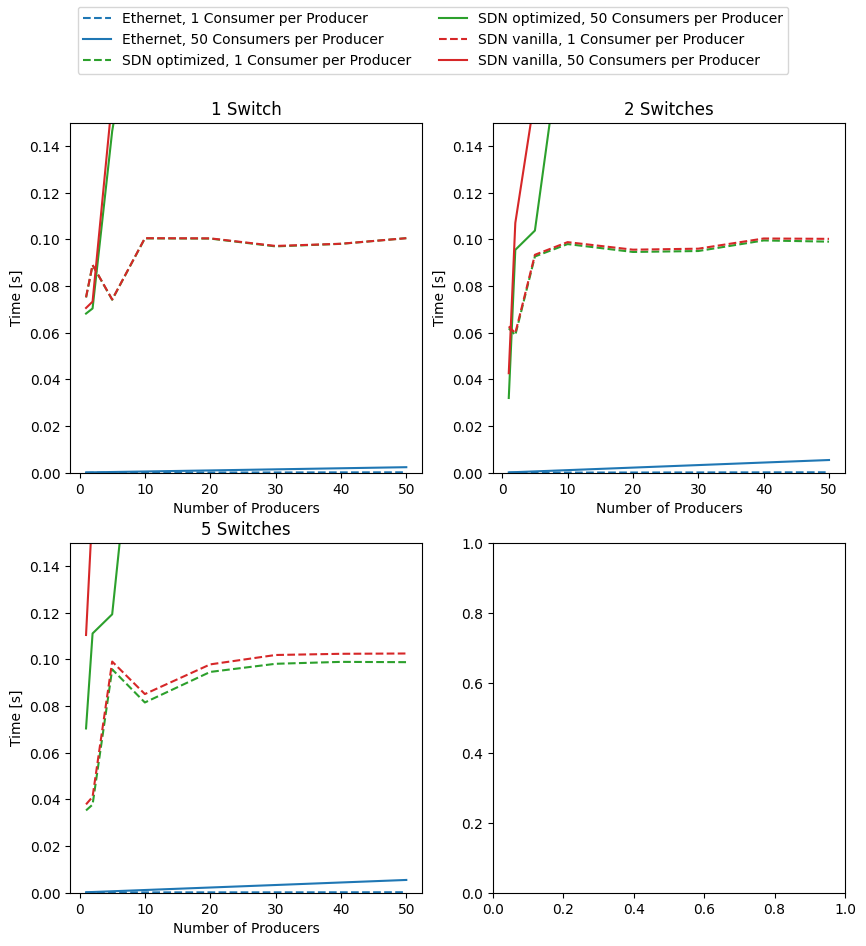

In [10]:
df_switches = dict()
df_sdn = dict()
df_vanilla = dict()
for S in switches:
    df_switches[S] = pd.DataFrame(switches[S])
    df_sdn[S] = pd.DataFrame(sdn[S])
    df_vanilla[S] = pd.DataFrame(vanilla[S])
# create 3 subplots switches, sdn, vanilla for each number of switches
fig, axs = plt.subplots(2,2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.2)
row = 0
column = 0
for S in switches:
    plt1 = df_switches[S][1].plot(ax=axs[row,column], legend=False, label="Ethernet, 1 Consumer per Producer", color="tab:blue", linestyle="--")
    df_switches[S][50].plot(ax=axs[row,column], legend=False, label="Ethernet, 50 Consumers per Producer", color="tab:blue")
    df_sdn[S][1].plot(ax=axs[row,column], legend=False, label="SDN optimized, 1 Consumer per Producer", color="tab:green", linestyle="--")
    df_sdn[S][50].plot(ax=axs[row,column], legend=False, label="SDN optimized, 50 Consumers per Producer", color="tab:green")
    df_vanilla[S][1].plot(ax=axs[row,column], legend=False, label="SDN vanilla, 1 Consumer per Producer", color="tab:red", linestyle="--")
    df_vanilla[S][50].plot(ax=axs[row,column], legend=False, label="SDN vanilla, 50 Consumers per Producer", color="tab:red")
    plt1.set_xlabel("Number of Producers")
    plt1.set_ylabel("Time [s]")
    if(S == 1):
        plt1.set_title(str(S) + " Switch")
    else:
        plt1.set_title(str(S) + " Switches")
    if(row == 0):
        axs[row,column].set_ylim(0, 0.15)
    else:
        axs[row,column].set_ylim(0, 0.15)
    # plt1.legend([str(x) + " Consumers per Producer" for x in df_switches[S].columns])
    column+=1
    if(column == 2):
        column = 0
        row += 1
# set legend for all subplots and append Consumers per Producer to legend
handles, labels = plt1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)
plt.show()



In [11]:
# export data needed for this plot
for S in switches:
    # export floats with precision of 9 digits
    df_switches[S][1].to_csv("ethernet_S=" + str(S) + "_C=1.csv", float_format='%.9f')
    df_switches[S][50].to_csv("ethernet_S=" + str(S) + "_C=50.csv", float_format='%.9f')
    df_sdn[S][1].to_csv("sdn_S=" + str(S) + "_C=1.csv", float_format='%.9f')
    df_sdn[S][50].to_csv("sdn_S=" + str(S) + "_C=50.csv", float_format='%.9f')
    df_vanilla[S][1].to_csv("vanilla_S=" + str(S) + "_C=1.csv", float_format='%.9f')
    df_vanilla[S][50].to_csv("vanilla_S=" + str(S) + "_C=50.csv", float_format='%.9f')
    